In [1]:
import flopy.mf6 as mf6
import flopy.plot as fplt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

After running the simulation, the outputs are saved to the output files directory. Luckily, you don't need to recreate and run the simulation every time you would like to visualize the outputs. 

Simply load in the simulation and grab the model objects, then retrieve the outputs from the model object!

## Load Simulation

In [2]:
# Load Simulation
sim = mf6.MFSimulation.load(sim_name='peterson', exe_name='../../mf6/bin/mf6.exe', sim_ws='../input-files/')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package ssm...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package ist...
    loading package mst...
    loading package ssm...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package

## Load Models

In [3]:
# Grab groundwater flow model from simulation
gwf = sim.get_model('peterson_flow')

# Grab transport model for each solute
gwt_pfos = sim.get_model('peterson_pfos')
gwt_pfoa = sim.get_model('peterson_pfoa')
gwt_pfhxs = sim.get_model('peterson_pfhsx')

## Visualizing Head Data

In [4]:
# read head outputs from model object
head_obj = gwf.output.head()

# Load data from final timestep
heads = head_obj.get_data()

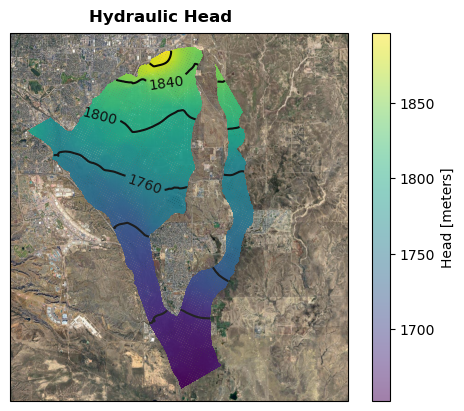

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,4), )#dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

vmax = heads[heads!=1e30].max()
vmin = heads[heads!=1e30].min()
cellhead = modelmap.plot_array(heads[0], ax=ax, cmap='viridis', 
                               transform=ccrs.UTM(13), alpha=0.5)
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

contour = modelmap.contour_array(heads[0], ax=ax, vmin=0,
                                 transform=ccrs.UTM(13), cmap='Grays')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')
ax.clabel(contour)

plt.suptitle('Hydraulic Head', weight='bold')
plt.show()

## Plot Flooded Cells

In [8]:
# Load in top elevation of layer
top_elev = np.loadtxt('../input-files/data-files/dis-top-elev.dat')

# Take difference between top elevation and head
diff = top_elev - heads[0]
diff_neg = np.where(diff < 0, diff, np.nan)  # Grab negative values (head > top)

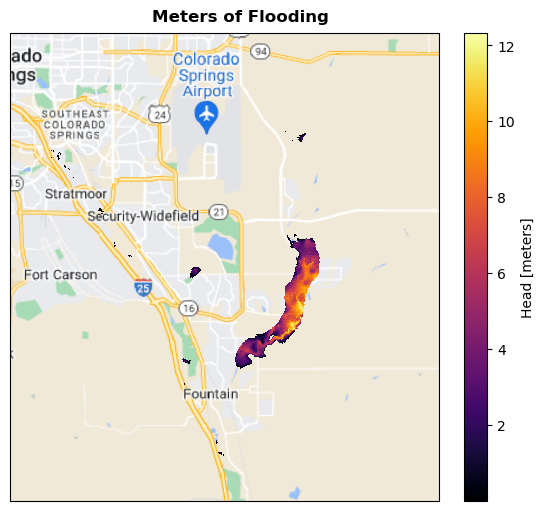

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,5))#, dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

cellhead = modelmap.plot_array(-diff_neg, ax=ax, cmap='inferno', transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

ggtiles = GoogleTiles()
ax.add_image(ggtiles, 11)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')

plt.suptitle('Meters of Flooding', weight='bold')
# plt.savefig('../figures/flooded-cells.png', bbox_inches='tight')
plt.show()

## Plot Observed vs Simulated Heads

In [ ]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../input-files/head_obs.csv', isBinary=False)
sim_df = obs_out.get_dataframe()

In [ ]:
# Set time index
sim_df.set_index('totim', inplace=True)
sim_df.head()

# Identify and rename columns in sim_df based on the naming pattern
sim_df.columns = [col.split('_')[1] if len(col.split('_')) > 2 else col.split('_')[1] for col in sim_df.columns]

# Remove duplicate columns by keeping the first occurrence
sim_df = sim_df.loc[:, ~sim_df.columns.duplicated()]
sim_df.head()

In [ ]:
# Initialize an empty list to store data
new_data = []

# Iterate over well_data and prepare the data
for well in well_data:
    if well['cell']:
        well_name = well['well_name']
        matched_heads = well['matched_heads']
        
        # Add entries as dictionaries for faster DataFrame creation
        for head in matched_heads:
            new_data.append({'time': head[0], well_name: head[1]})

# Create a DataFrame from the list of dictionaries
obs_df = pd.DataFrame(new_data).set_index('time')

# Concatenate times
obs_df = obs_df.groupby(obs_df.index).mean()
obs_df.head()

In [ ]:
# Align sim_df and obs_df by their common indices
common_index = sim_df.index.intersection(obs_df.index)

# Use only the rows corresponding to the common index
sim_df_aligned = sim_df.loc[common_index]
obs_df_aligned = obs_df.loc[common_index]

In [ ]:
fig, ax = plt.subplots()

for col in sim_df.columns:
    ax.scatter(obs_df_aligned[col], sim_df_aligned[col], color='r')

ax.set_xlabel('Observed Heads')
ax.set_ylabel('Simulated Heads')
ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

## Plot Concentration Results

In [13]:
# Get solute concentrations
PFOS = gwt_pfos.output.concentration().get_alldata()
PFOA = gwt_pfoa.output.concentration().get_alldata()
PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [15]:
PFOS.shape, PFOA.shape, PFHxS.shape

((351, 1, 972, 700), (351, 1, 972, 700), (350, 1, 972, 700))

In [17]:
import imageio

In [ ]:
for i in range(350):
    fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
    ax1, ax2, ax3 = axs
    
    modelmap = fplt.PlotMapView(model=gwt_pfos)
    
    # plot PFOS
    vmax = PFOS[PFOS != 1e30].max()
    norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
    cellhead = modelmap.plot_array(PFOS[i][0], ax=ax1, cmap='inferno', norm=norm,
                                   transform=ccrs.UTM(13))
    fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')
    
    # Plot PFOA
    vmax = PFOA[PFOA != 1e30].max()
    norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
    cellhead = modelmap.plot_array(PFOA[i][0], ax=ax2, cmap='inferno', norm=norm, 
                                   transform=ccrs.UTM(13))
    fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')
    
    # Plot PFHxS
    vmax = PFHxS[PFHxS != 1e30].max()
    norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
    cellhead = modelmap.plot_array(PFHxS[i][0], ax=ax3, cmap='inferno', norm=norm, 
                                   transform=ccrs.UTM(13))
    fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')
    
    titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
    for ax, title in zip(axs, titles):
        ggtiles = GoogleTiles(style='satellite')
        ax.add_image(ggtiles, 13)
        
        ax.set_title(title, weight='bold')
    
    plt.savefig(f'../figures/gif-pngs/sp-{i}.png')
    plt.close()

pngs = [imageio.v2.imread(f'../figures/gif-pngs/sp-{i}.png') for i in range(350)]

imageio.mimsave('../figures/concentrations.gif', pngs, duration=50, loop=0)

<urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>


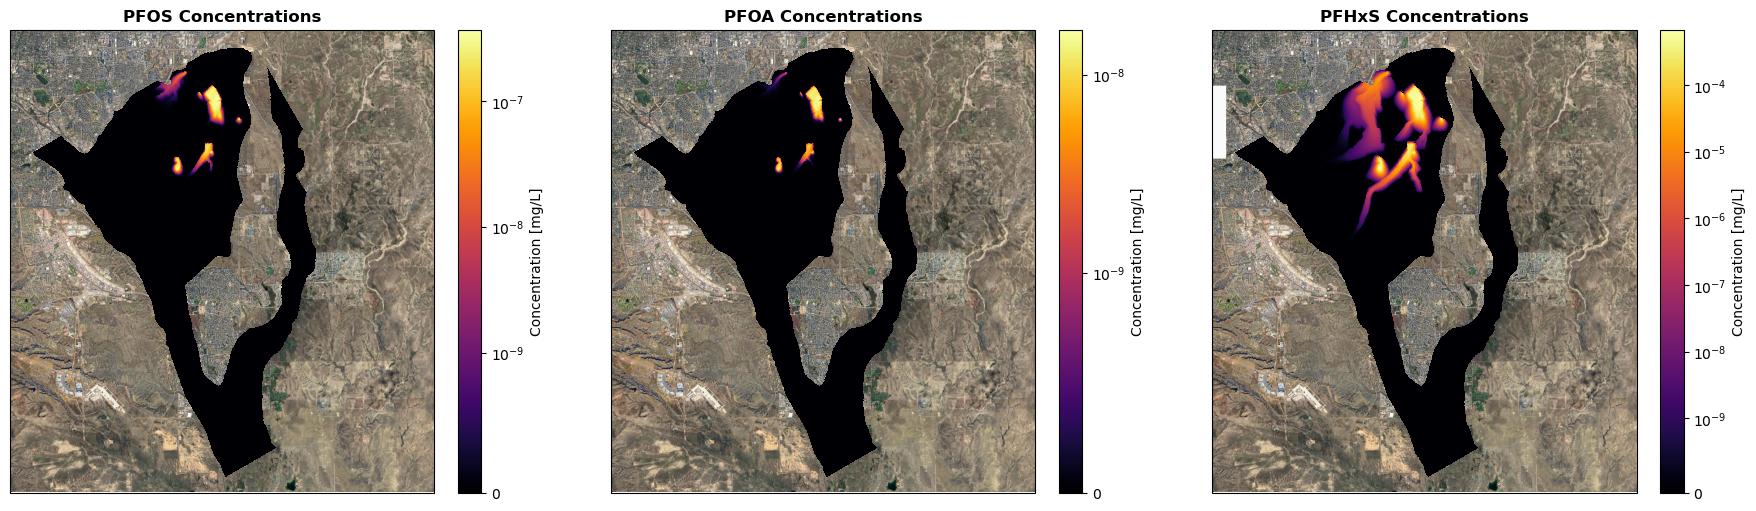

In [20]:
fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
ax1, ax2, ax3 = axs

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFOS[0], ax=ax1, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')

# Plot PFOA
vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFOA[0], ax=ax2, cmap='inferno', norm=norm, 
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')

# Plot PFHxS
vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cellhead = modelmap.plot_array(PFHxS[0], ax=ax3, cmap='inferno', norm=norm, 
                               transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')

titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
for ax, title in zip(axs, titles):
    ggtiles = GoogleTiles(style='satellite')
    ax.add_image(ggtiles, 13)
    
    ax.set_title(title, weight='bold')

plt.show()